## Import and Set up

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve
)

RANDOM_STATE = 42

pairs = pd.read_csv("../data/processed/pairs.csv")
emb = np.load("../data/processed/embeddings.npy")

pairs.head()


,idx1,idx2,same
0,889,722,0
1,5451,10884,0
2,4262,7558,0
3,10319,241,1
4,7449,880,1


## Feature engineering

We combine four standard verification features:
- |e1 − e2|
- e1 * e2
- cosine similarity
- L2 distance

In [4]:
e1 = emb[pairs.idx1.values]
e2 = emb[pairs.idx2.values]

abs_diff = np.abs(e1 - e2)
prod = e1 * e2

cos_sim = np.sum(e1 * e2, axis=1, keepdims=True)
l2_dist = np.linalg.norm(e1 - e2, axis=1, keepdims=True)

X = np.hstack([abs_diff, prod, cos_sim, l2_dist])
y = pairs.same.values

print("Feature matrix shape:", X.shape)


Feature matrix shape: (16800, 1026)


In [14]:
abs_diff.shape

(16800, 512)

## Train/validation split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


## Logistic Regression and Tuning

In [6]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

model = grid.best_estimator_
print("Best C:", grid.best_params_["C"])


Best C: 10


## Evaluation

In [7]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print("Accuracy :", accuracy_score(y_val, y_pred))
print("F1 score :", f1_score(y_val, y_pred))
print("ROC AUC  :", roc_auc_score(y_val, y_prob))


Accuracy : 0.9833333333333333
F1 score : 0.9833234067897558
ROC AUC  : 0.9978815901360545


## ROC Curve

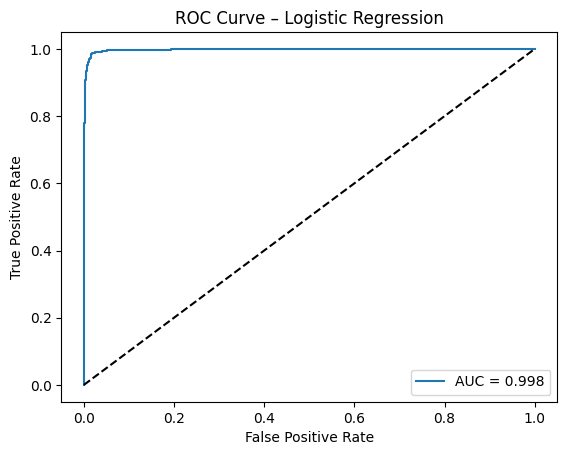

In [8]:
fpr, tpr, _ = roc_curve(y_val, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_prob):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()


## Feature importance intuition

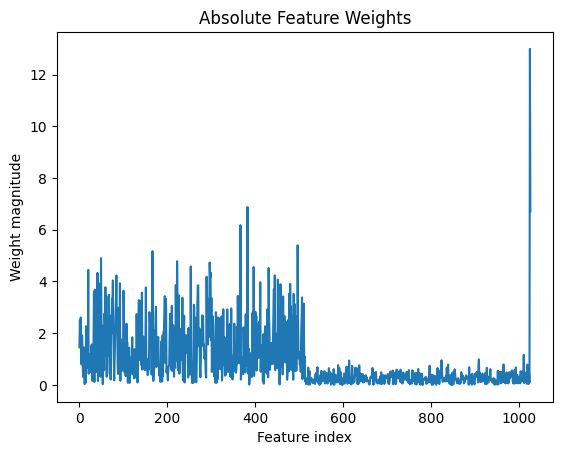

In [9]:
coef = np.abs(model.coef_[0])

plt.plot(coef)
plt.title("Absolute Feature Weights")
plt.xlabel("Feature index")
plt.ylabel("Weight magnitude")
plt.show()


This plot shows that the last features are the most importance which are the cosine distance and the L2 distance. Next the difference in each dimension is also important and the least important features are the products of the embeddings.